# Understand how TensorFlow Dataset API reads dataset progressively
To demonstrate the progressive reading of dataset

## Make a dummy sample

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [57]:
df = pd.DataFrame({'x':range(3000), 'y':np.random.randn(3000)})
df['z'] = df.x + df.y * np.sqrt(df.x)

for i in [0, 1, 2]:
    dfi = df.iloc[1000 * i : 1000 * (i + 1)]
    dfi.to_csv(f'sample.csv-{i}', header=False, index=False)

## Use TensorFlow Dataset API
We are going to read the three smaller files

In [37]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [38]:
csv_columns = ['x', 'y', 'z']
defaults = [[1.0], [1.0], [1.0]]

def read_dataset(filename, batch_size=3):
    def decode_line(row):
        cols = tf.decode_csv(row, record_defaults=defaults)
        features = {}
        for i, col in zip(range(len(csv_columns)-1), csv_columns[:-1]):
            features[col] = cols[i]
        label = cols[-1]
        return features, label
        
    dataset = tf.data.Dataset.list_files(filename + '-*', shuffle=False) # default shuffle order of files randomly
    dataset = dataset.flat_map(tf.data.TextLineDataset).map(decode_line)
    dataset = dataset.batch(batch_size)
    dataset = dataset.make_one_shot_iterator().get_next()  # only takes effect in model training
  
    return dataset

In [39]:
test = read_dataset('sample.csv', batch_size=8)

In [40]:
# execute the test node, it only have batch_size samples.
with tf.Session() as sess:
    print(sess.run(test))

({'x': array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), 'y': array([ 0.44659486,  0.21415916, -1.6992335 ,  1.063166  ,  0.2578529 ,
       -0.75224745,  1.1340697 , -0.7952736 ], dtype=float32)}, array([0.44659486, 1.2141591 , 0.30076647, 4.063166  , 4.257853  ,
       4.2477527 , 7.13407   , 6.204726  ], dtype=float32))


In [41]:
# execute the test node again, won't get next 8 values
with tf.Session() as sess:
    print(sess.run(test))

({'x': array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), 'y': array([ 0.44659486,  0.21415916, -1.6992335 ,  1.063166  ,  0.2578529 ,
       -0.75224745,  1.1340697 , -0.7952736 ], dtype=float32)}, array([0.44659486, 1.2141591 , 0.30076647, 4.063166  , 4.257853  ,
       4.2477527 , 7.13407   , 6.204726  ], dtype=float32))


## Feed data to a linear regression model

In [42]:
feat_cols = [tf.feature_column.numeric_column('x'),
             tf.feature_column.numeric_column('y')]

def train_input_fn(): #(filename, batch_size):
    return read_dataset('sample.csv', 56)

In [43]:
model = tf.estimator.LinearRegressor(feat_cols)
model.train(input_fn = train_input_fn, steps=1000)

W1030 16:00:55.693110 140179253536576 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpbj7wt460


In [44]:
pred = model.predict(train_input_fn)

In [45]:
z_pred = np.array([pr['predictions'] for pr in pred])

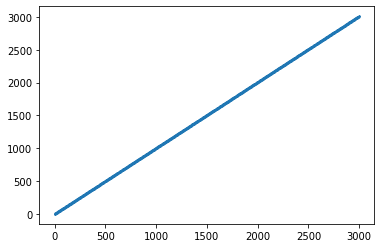

In [48]:
plt.scatter(range(3000), z_pred, s=1)

### DNN model

In [58]:
dnn = tf.estimator.DNNRegressor([32,8], feat_cols)
dnn.train(train_input_fn)

W1030 16:29:33.975753 140179253536576 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpj4u515_7


In [59]:
pred = dnn.predict(train_input_fn)
z_pred = np.array([pr['predictions'] for pr in pred])

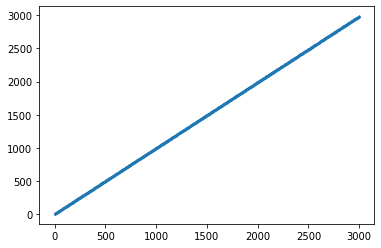

In [60]:
plt.scatter(range(3000), z_pred, s=1)

### How to compare predictions to true values

In [ ]:
z = 